## **Generative Adversarial Networks (GANs)**

**made by Anas Aldadi**

The idea and implementation behind vanilla GANs is pretty much easy! but unfortunately it will be very hard to make it generate acceptable realistic looking results, and this notebook has been made to show different ways to do GANs.
So, its a comprehensive notebook that will demonstrate the different archetictures of GANs.

---
different GAN losses will be explained here such as non-saturating loss, Wasserstein loss, and hinge loss.

---
<img src="https://drive.google.com/uc?id=1cH0CvCwmN0NC1nhG5EU7jOqziZdsVnGX" width="1000"/>

[image source](https://www.researchgate.net/publication/343786287_Generative_Adversarial_Networks_for_Spatio-temporal_Data_A_Survey)

Note: D is Discriminator (simply put a classifier) and G is Generator (simply put a Decoder or any archeticture that reconstruct or upsample)

the GANs variations i will summerize are:

* [GAN (2014)](https://arxiv.org/abs/1406.2661) Ian Goodfellow et al. Generative Adversarial Networks

* [DCGAN (2015)](https://arxiv.org/abs/1511.06434) Alec Radford et al. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

* [cGAN (2014)](https://arxiv.org/abs/1411.1784) Mehdi Mirza & Simon Osindero. Conditional Generative Adversarial Nets

* [infoGAN (2016)](https://arxiv.org/abs/1606.03657) Xi Chen et al. Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets

* [Pix2Pix GAN (2016)](https://arxiv.org/abs/1611.07004) Phillip et al. Image-to-Image Translation with Conditional Adversarial Networks

* [CycleGAN (2017)](https://arxiv.org/abs/1703.10593) Jun et al. Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

* [WGAN (2017)](https://arxiv.org/abs/1701.07875) Martin et al. Wasserstein GAN

* [WGAN-GP (2017)](https://arxiv.org/abs/1704.00028) Ishaan et al. Improved Training of Wasserstein GANs

* [SAGAN (2018)](https://arxiv.org/abs/1805.08318) Han Zhang et al. Self-Attention Generative Adversarial Networks

---
in another notebook i will tackle one of the densiest kinds of GAN:

* [StyleGAN (2018)](https://arxiv.org/abs/1812.04948) Tero et al. A Style-Based Generator Architecture for Generative Adversarial Networks

* [StyleGAN2 (2019)](https://arxiv.org/abs/1912.04958) Tero et al. Analyzing and Improving the Image Quality of StyleGAN

* [StyleGAN3 (2021)](https://arxiv.org/abs/1912.04958) Tero et al. Alias-Free Generative Adversarial Networks



---

Some kinds of GANs which are not covered:
* [ACGAN (2016)](https://arxiv.org/pdf/1610.09585) Odena et al. Conditional Image Synthesis with Auxiliary Classifier GANs

* [SGAN (2016)](https://arxiv.org/pdf/1606.01583) Odena. Semi-Supervised Learning with Generative Adversarial Networks

* [StackGAN (2016)](https://arxiv.org/abs/1612.03242) Zhang et al. StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks

* [DiscoGAN (2017)](https://arxiv.org/pdf/1703.05192) Kim et al. Learning to Discover Cross-Domain Relations
with Generative Adversarial Networks

* [HDCGAN (2017)](https://arxiv.org/pdf/1711.06491) Curto et al. High-resolution Deep Convolutional Generative Adversarial Networks



## Reqs and Data (not important to learn about)

its a subset of imagenet that we will use for all the kinds of GANs to learn and generate from

### Reqs

#### Dependencies

In [ ]:
import torch, torchvision

# torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
from torchvision.utils import make_grid

# Others
import glob, re, shutil, os, gc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from math import log, sqrt, pi
import argparse
from IPython.display import Image as IPyImage, display
import random
import time
from IPython.display import clear_output
import itertools

In [ ]:
!pip install torchsummary
from torchsummary import summary
clear_output()

In [ ]:
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


#### Helpers

##### Utility

In [ ]:
def flush_gpu(device=None, verbose=True):
    """
    Releases unused GPU memory by clearing cache and collecting garbage.

    Args:
        device (torch.device or int, optional): Device to flush. Defaults to current CUDA device.
        verbose (bool): If True, prints memory info before/after flushing.
    """
    if not torch.cuda.is_available():
        if verbose:
            print("CUDA is not available.")
        return

    device = device or torch.cuda.current_device()
    torch.cuda.synchronize(device)

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[Before] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[After]  Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [ ]:
def natural_sort_key(path):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', path)]

##### Image functions

In [ ]:
def preprocess_img(img, is_normalized):
    if is_normalized: img = (img * 0.5 + 0.5).clamp(0, 1) # if you applied normalization to change the range from [0 to 1] to [-1 to 1]
    # img = img.clamp(0, 255).to(torch.uint8)  # if the values of the image are int
    return img.cpu().permute(1,2,0)
def show(img, is_normalized=True):
    img = preprocess_img(img, is_normalized)
    plt.imshow(img)
    plt.axis('off')

##### CNN functions

In [ ]:
def calc_transpose_conv2d_output_dim(input_size, kernel_size, stride, padding, output_padding=0):
    """
    Calculate the output height or width of a 2D transposed convolution layer.

    Parameters:
    - input_size (int): Size of input height or width
    - kernel_size (int): Size of the convolution kernel
    - stride (int): Stride of the convolution
    - padding (int): Padding added to the input
    - output_padding (int): Additional size added to one side of the output (default 0)

    Returns:
    - int: Output dimension (height or width)
    """
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding


In [ ]:
def calc_conv2d_output_dim(input_size, kernel_size, stride, padding, dilation=1):
    """
    Calculate the output height or width of a 2D convolution layer.

    Parameters:
    - input_size (int): Size of input height or width
    - kernel_size (int): Size of the convolution kernel
    - stride (int): Stride of the convolution
    - padding (int): Padding added to the input
    - dilation (int): Dilation rate (default is 1)

    Returns:
    - int: Output dimension (height or width)
    """
    return ((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1


#### Data loading

In [ ]:
import kagglehub
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")
print("Path to dataset files:", path)

100%|██████████| 283M/283M [00:04<00:00, 72.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1/celeba_hq_256

00000.jpg  04286.jpg  08572.jpg  12858.jpg  17144.jpg  21430.jpg  25716.jpg
00001.jpg  04287.jpg  08573.jpg  12859.jpg  17145.jpg  21431.jpg  25717.jpg
00002.jpg  04288.jpg  08574.jpg  12860.jpg  17146.jpg  21432.jpg  25718.jpg
00003.jpg  04289.jpg  08575.jpg  12861.jpg  17147.jpg  21433.jpg  25719.jpg
00004.jpg  04290.jpg  08576.jpg  12862.jpg  17148.jpg  21434.jpg  25720.jpg
00005.jpg  04291.jpg  08577.jpg  12863.jpg  17149.jpg  21435.jpg  25721.jpg
00006.jpg  04292.jpg  08578.jpg  12864.jpg  17150.jpg  21436.jpg  25722.jpg
00007.jpg  04293.jpg  08579.jpg  12865.jpg  17151.jpg  21437.jpg  25723.jpg
00008.jpg  04294.jpg  08580.jpg  12866.jpg  17152.jpg  21438.jpg  25724.jpg
00009.jpg  04295.jpg  08581.jpg  12867.jpg  17153.jpg  21439.jpg  25725.jpg
00010.jpg  04296.jpg  08582.jpg  12868.jpg  17154.jpg  21440.jpg  25726.jpg
00011.jpg  04297.jpg  08583.jpg  12869.jpg  17155.jpg  21441.jpg  25727.jpg
00012.jpg  04298.jpg  08584.jpg  12870.jpg  17156.jpg  21442.jpg  25728.jpg
00013.jpg  0

In [ ]:
root = path+'/celeba_hq_256'

In [ ]:
class LoadingData(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)
        return img
channels=3; size=64
transformss = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
datasett = LoadingData(root, transformss)
celeba_dl = DataLoader(datasett, batch_size=12, num_workers=os.cpu_count(), persistent_workers=True, shuffle=True)

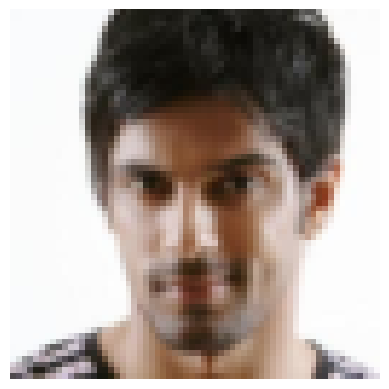

In [ ]:
img = next(iter(celeba_dl))
show(img[0], is_normalized=True)

In [ ]:
torch.min(img[0]), torch.max(img[0])

(tensor(-0.9451), tensor(1.))

In [ ]:
class MNISTSegment(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        super().__init__()
        self.dataset = MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

In [ ]:
size1=32; size2=28
# data transformations
transform1 = transforms.Compose([
    transforms.ToTensor(),
    T.Resize((size1, size1)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    T.Resize((size2, size2)),
])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform1)
mnist_dl = DataLoader(mnist_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=os.cpu_count())

mnist_dataset28 = datasets.MNIST(root='./data', train=True, download=True, transform=transform2)
mnist_dl28 = DataLoader(mnist_dataset28, batch_size=512, shuffle=True, pin_memory=True, num_workers=os.cpu_count())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.10MB/s]


## Vanilla GANs

we will start with DCGAN which stands for Deep Convolutional Generative Adversarial Network
* [GAN (2014)](https://arxiv.org/abs/1406.2661) Ian Goodfellow et al. Generative Adversarial Networks

* [DCGAN (2015)](https://arxiv.org/abs/1511.06434) Alec Radford et al. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

In [ ]:
output_dim = calc_transpose_conv2d_output_dim(
    input_size=1,
    kernel_size=4,
    stride=1,
    padding=0,
    output_padding=0
)
print(output_dim)

4


In [ ]:
output_dim = calc_conv2d_output_dim(
    input_size=4,
    kernel_size=3,
    stride=1,
    padding=1,
    dilation=1
)
print(output_dim)

4


### Generator

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def deconv_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class VanillaGenerator(nn.Module):
    def __init__(self, num_channels, num_filters, latent_dims):
        super().__init__()
        self.num_channels = num_channels
        self.num_filters = num_filters
        self.latent_dims = latent_dims

        # the goal is to take latent  (batch_size, latent_dims, 1, 1) and upsample it to (num_channels, 64, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, num_filters*8, kernel_size=4, stride=1, padding=0),  # 1 -> 4
            nn.ReLU(),
            conv_block(num_filters*8, num_filters*8),


            deconv_block(num_filters*8, num_filters*8),  # 4->8
            conv_block(num_filters*8, num_filters*8),

            deconv_block(num_filters*8, num_filters*4),  # 8->16
            conv_block(num_filters*4, num_filters*4),

            deconv_block(num_filters*4, num_filters*2),  # 16->32
            conv_block(num_filters*2, num_filters*2),

            deconv_block(num_filters*2, num_filters),    # 32->64

            # nn.Conv2d(num_filters, num_channels, kernel_size=1, stride=1, padding=0), # 64 -> 64 (btw this is 1x1 conv so it will work like an activation function and produce normalized output)
            nn.Conv2d(num_filters, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, latent):
        # The latent input has shape (batch_size, latent_dims), and we reshape it to (batch_size, latent_dims, 1, 1)
        out = latent.view(latent.size(0), self.latent_dims, 1, 1)
        fake = self.decoder(out)
        return fake

In [ ]:
generator = VanillaGenerator(num_channels=3, num_filters=32, latent_dims=100)
print(f'number of params: {sum([p.numel() for p in generator.parameters()]):,}')

number of params: 2,755,139


In [ ]:
summary(generator, input_size=(100,1,1), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,856
              ReLU-2            [-1, 256, 4, 4]               0
            Conv2d-3            [-1, 256, 4, 4]         590,080
       BatchNorm2d-4            [-1, 256, 4, 4]             512
              ReLU-5            [-1, 256, 4, 4]               0
   ConvTranspose2d-6            [-1, 256, 8, 8]         590,080
       BatchNorm2d-7            [-1, 256, 8, 8]             512
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
  ConvTranspose2d-12          [-1, 128, 16, 16]         295,040
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

torch.Size([8, 3, 64, 64])


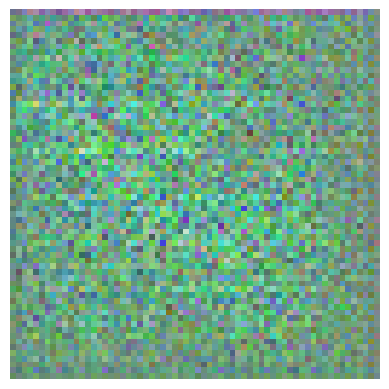

In [ ]:
z = torch.randn(8, 100)  # batch of 8 latent vectors
out = generator(z)
print(out.shape)  # torch.Size([8, 3, 64, 64])
show(out[0].detach())

In [ ]:
torch.min(out[0].detach()), torch.max(out[0].detach())

(tensor(-0.8397), tensor(0.9446))

#### Weight initialization

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
generator.apply(weights_init)

VanillaGenerator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 

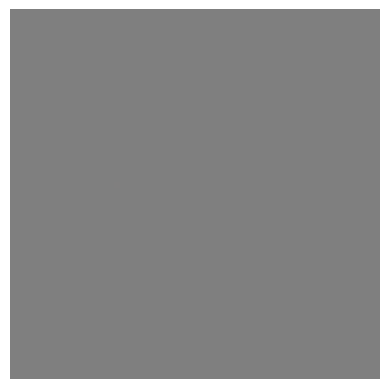

In [ ]:
z = torch.randn(8, 100)  # batch of 8 latent vectors
out = generator(z)
show(out[0].detach())

### Discriminator

In [ ]:
output_dim = calc_conv2d_output_dim(
    input_size=4,
    kernel_size=4,
    stride=2,
    padding=1,
    dilation=1
)
print(output_dim)

2


In [ ]:
class VanillaDiscriminator(nn.Module):
    def __init__(self, num_channels, num_filters, num_neurons, dropout_prob):
        super().__init__()
        self.num_channels = num_channels
        self.num_filters = num_filters
        self.num_neurons = num_neurons
        self.dropout_prob = dropout_prob

        # the goal is to take an image of 64,64,3 and classify it if its generated or real
        # a piece of advice here, from papers like DCGAN it is adviced to avoid batch norm layers in the first layer in the discriminator
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(num_channels, num_filters*2, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.LeakyReLU(0.2),

            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.BatchNorm2d(num_features=num_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(num_filters*4, num_filters*8, kernel_size=3, stride=2, padding=1), # 16 -> 8
            nn.BatchNorm2d(num_features=num_filters*8),
            nn.LeakyReLU(0.2),

            nn.Dropout(p=dropout_prob)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.LazyLinear(num_neurons*2),
            nn.LeakyReLU(0.2),

            nn.LazyLinear(num_neurons),
            nn.LeakyReLU(0.2),

            nn.LazyLinear(1),
        )

    def forward(self, img):
        compressed = self.feature_extractor(img)
        logits = self.classifier(compressed)
        return logits

In [ ]:
discriminator = VanillaDiscriminator(num_channels=3, num_filters=32, num_neurons=50, dropout_prob=.2)
summary(discriminator, input_size=(3,64,64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         295,168
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
           Dropout-9            [-1, 256, 8, 8]               0
          Flatten-10                [-1, 16384]               0
           Linear-11                  [-1, 100]       1,638,500
        LeakyReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 50]           5,050
        LeakyReLU-14                   

In [ ]:
rand_img = torch.randn(2, 3,64,64)
logit = discriminator(rand_img)

In [ ]:
print(torch.sigmoid(logit.detach()))

tensor([[0.5205],
        [0.4988]])


### vanilla GAN

In [ ]:
class VanillaGAN(nn.Module):
    def __init__(self, num_channels=3, num_filters=64, latent_dims=100, num_neurons=50, dropout_prob=.2):
        super().__init__()
        self.generator = VanillaGenerator(num_channels=num_channels, num_filters=num_filters, latent_dims=latent_dims)
        self.discriminator = VanillaDiscriminator(num_channels=num_channels, num_filters=num_filters, num_neurons=num_neurons, dropout_prob=dropout_prob)

    def generate(self, latent):
        return self.generator(latent)

    def discriminate(self, img):
        return self.discriminator(img)

    def forward(self, img, latent):
        fake = self.generate(latent)
        fake_logits = self.discriminate(fake)
        real_logits = self.discriminate(img)

        return {
            'fake_logits': fake_logits,
            'real_logits': real_logits,
            'fake_images': fake  # optional
        }

    @torch.no_grad()
    def sample(self, batch_size, device='cpu'):
        latent = torch.randn(batch_size, self.generator.latent_dims, device=device)
        return self.generate(latent)



In [ ]:
# you might ask why one type of loss for both generator and discriminator?
# answer because this is vanilla gan simple and stupid

criterion = nn.BCEWithLogitsLoss()
gan = VanillaGAN().to(device)
g_optimizer = torch.optim.Adam(gan.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(gan.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
g_history, d_history = [], []

In [ ]:
def train_step(gan, real_images, g_optimizer, d_optimizer, criterion, device='cuda'):
    batch_size = real_images.size(0)

    # === Train Discriminator ===
    gan.discriminator.train()
    gan.generator.eval()  # Optional: freeze G while training D

    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size, 1), device=device)
    fake_labels = torch.zeros((batch_size, 1), device=device)

    # Generate fake images
    latent = torch.randn(batch_size, gan.generator.latent_dims, device=device)
    with torch.no_grad():
        fake_images = gan.generate(latent)

    # Get logits
    real_logits = gan.discriminate(real_images)
    fake_logits = gan.discriminate(fake_images)

    # Discriminator loss
    d_loss_real = criterion(real_logits, real_labels)
    d_loss_fake = criterion(fake_logits, fake_labels)
    d_loss = d_loss_real + d_loss_fake

    # Backprop + update discriminator
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # === Train Generator ===
    gan.generator.train()
    gan.discriminator.eval()  # Optional: freeze D while training G

    latent = torch.randn(batch_size, gan.generator.latent_dims, device=device)
    fake_images = gan.generate(latent)
    fake_logits = gan.discriminate(fake_images)

    # Generator loss: try to make fake logits look like real
    g_loss = criterion(fake_logits, real_labels)

    # Backprop + update generator
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return {
        'd_loss': d_loss.item(),
        'g_loss': g_loss.item()
    }


In [ ]:
epochs=1

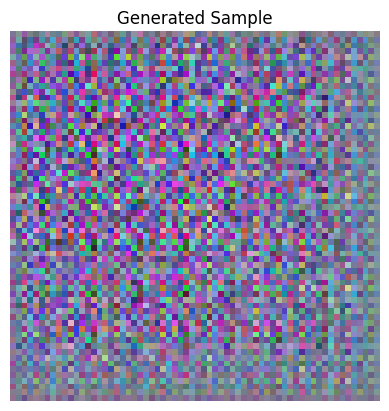

100%|██████████| 1/1 [01:56<00:00, 116.32s/it]


In [ ]:
for epoch in tqdm(range(epochs)):
    for i, real_images in enumerate(celeba_dl):

        history = train_step(gan, real_images, g_optimizer, d_optimizer, criterion, device='cuda')
        g_loss, d_loss = history['g_loss'], history['d_loss']
        g_history.append(g_loss); d_history.append(d_loss)
        if i % 100 == 0:
            # Generate fake images
            fake_images = gan.sample(batch_size=1, device=device)

            # Display first generated image
            clear_output(wait=True)  # clear previous plot
            img = fake_images[0].detach().cpu()
            img = (img + 1) / 2  # normalize from [-1,1] to [0,1]
            plt.imshow(img.squeeze().permute(1, 2, 0).clip(0, 1))
            plt.title("Generated Sample")
            plt.axis("off")
            plt.pause(0.001)  # allow plot to update without blocking

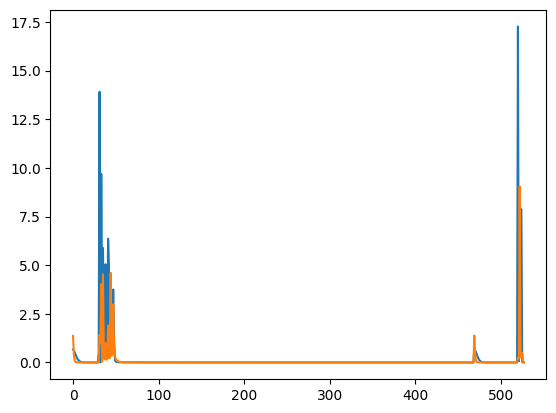

In [ ]:
plt.plot(g_history, label='generator')
plt.plot(d_history, label='discriminator')

The definition of unstable learning and model collapsing lol

As you can see it poorly performed because of many things and one of them the resolution is too high for this model to learn, if we try mnist it would perform much much better

## cGAN
* [cGAN (2014)](https://arxiv.org/abs/1411.1784) Mehdi Mirza & Simon Osindero. Conditional Generative Adversarial Nets

conditional version of generative adversarial nets (GANs),

which can be  constructed by simply feeding the data, y, we wish
to condition on to both the generator and discriminator.

this model can generate MNIST digits conditioned on class labels, which will be demonstrated in this section.

---
<img src="https://drive.google.com/uc?id=1aCEd-9YWuo8ZQJUtvT4BJrYVHsjm-Ndw" width="500"/>

This shows the archeticture of conditional gans as you can notice both the generator and the discriminator we concatenate two things:

For the generator it takes the latent Z and the label y (we concatenate them).

There are two ways of concatenating, one is adding them, and another is appending (which we will use).

For the discriminator we also concatenate the inputs image x (can be the real images or the fake) and the corresponding label y




---


Below is the data we will condition on!, the image and its label

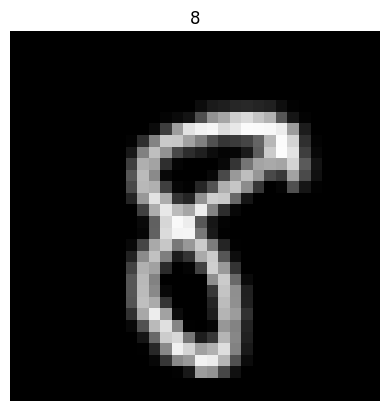

In [ ]:
image, label = next(iter(mnist_dl))
plt.title(f'{label[0]}')
show(image[0], is_normalized=False)

In [ ]:
torch.min(image[0]), torch.max(image[0])

(tensor(0.), tensor(0.9889))

**Conditioning**

to include extra information other than the original input we need to concatenate the original input with the extra information (in our case here we are giving the generator the information of what number it should generate - as for the discriminator we are telling it what number the given image is)

Two ways to include this information:

* generate an embedding of the labels from 0-9 using nn.Embedding (we won't use it as the original paper haven't done this)

* one hot encoding the labels (e.g. 1 = [0,1,0,0,0,0,0,0,0,0])

which is a naive approach to include the information of the label but for the sake of sticking to the paper we're doing it. [ref](https://arxiv.org/pdf/1411.1784)

<img src="https://drive.google.com/uc?id=1khwNTy0G-12dpALyxjFpjhEGaBGSv3Ps" width="800"/>


In [ ]:
num_classes = 10
y_onehot = F.one_hot(label, num_classes=num_classes).float()
y_onehot.shape

torch.Size([512, 10])

as you can see the batch size is 512 and every row has 10 columns corresponding to its number.

if we take a closer look, the y_onehot looks like this

```
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], <- this is corresponding to label = 5
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
```



In [ ]:
y_onehot[:3]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

#### Concatentation simple quick guide

* Concatenates along dimension 0 (rows)

* Think of it as vertical stacking (we add the rows)

* It adds more rows, so tensors must have the same number of columns

In [ ]:
# Example
a = torch.tensor([[1, 2],
                  [3, 4]])          # shape (2, 2)

b = torch.tensor([[5, 6]])          # shape (1, 2)

print(f'{torch.concat((a, b), dim=0)}')
print(f'\nshape is {torch.concat((a, b), dim=0).shape}')

tensor([[1, 2],
        [3, 4],
        [5, 6]])

shape is torch.Size([3, 2])


* Concatenates along dimension 1 (columns)

* Think of it as horizontal stacking (we add the columns)

* It adds more columns, so tensors must have the same number of rows

In [ ]:
# Example
a = torch.tensor([[1, 2],
                  [3, 4]])          # shape (2, 2)

b = torch.tensor([[5], [6]])        # shape (2, 1)

print(f'{torch.concat((a, b), dim=1)}')
print(f'\nshape is {torch.concat((a, b), dim=1).shape}')

tensor([[1, 2, 5],
        [3, 4, 6]])

shape is torch.Size([2, 3])


In [ ]:
ones = torch.ones([2,2])
zeros = torch.zeros([2,1])
ones, zeros

(tensor([[1., 1.],
         [1., 1.]]),
 tensor([[0.],
         [0.]]))

In [ ]:
print(torch.concat([ones, zeros.view(1,-1)], dim=0) == torch.vstack([ones, zeros.view(1,-1)]))
torch.vstack([ones, zeros.view(1,-1)])

tensor([[True, True],
        [True, True],
        [True, True]])


tensor([[1., 1.],
        [1., 1.],
        [0., 0.]])

In [ ]:
print(torch.concat([ones, zeros], dim=1) == torch.hstack([ones,zeros]))

torch.hstack([ones,zeros])

tensor([[True, True, True],
        [True, True, True]])


tensor([[1., 1., 0.],
        [1., 1., 0.]])

### Generator

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def deconv_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class cGenerator(nn.Module):
    def __init__(self, num_classes, latent_dims, num_channels, num_filters):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dims = latent_dims
        self.num_channels = num_channels
        self.num_filters = num_filters

        self.decode = nn.Sequential(
            # NOTICE HERE:
            nn.ConvTranspose2d(
                                latent_dims+num_classes # notice in the in_channels parameter we added num_classes since we concatenated the num_channels with z! so in the first conv we must add it too!
                               , num_filters*8, kernel_size=4, stride=1, padding=0),  # 1 -> 4
            nn.ReLU(),
            conv_block(num_filters*8, num_filters*8),

            deconv_block(num_filters*8, num_filters*8),  # 4->8
            conv_block(num_filters*8, num_filters*8),

            deconv_block(num_filters*8, num_filters*4),  # 8->16
            conv_block(num_filters*4, num_filters*4),

            deconv_block(num_filters*4, num_filters*2),  # 16->32
            nn.Conv2d(num_filters*2, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # sigmoid because MNIST range is [0, 1]
        )

    def forward(self, z, y):
        # rember that z is [batch size, 100, 1, 1]  <- this is the data
        # and that y is    [batch size]         <- this is the condition
        # so we for every example in the batch to
        # add the information of the label and to
        # do that we will horizontal stack them
        y = y.long()
        y_one_hot = F.one_hot(y, num_classes=self.num_classes)
        # now y_one_hot is [batch size, 10]
        # make the y_one_hot to be [batch size, 10, 1, 1]
        # to be able to concat with z
        y_one_hot = y_one_hot.view(-1,self.num_classes,1,1)

        #concate horizontally with z
        input = torch.concat([z, y_one_hot], dim=1)
        # the shape now is [batch size, latent_dims+num_classes, 1, 1]
        # and since latent_dims is 100 and num_classes is 10 it becomes
        # [batch size, 100+10, 1, 1]
        fake = self.decode(input)
        return fake

In [ ]:
num_classes = 10
latent_dims = 100
num_channels = 3

cgenerator = cGenerator(num_classes=num_classes, latent_dims=latent_dims, num_channels=num_channels, num_filters=24)
print(f'number of params: {sum([p.numel() for p in cgenerator.parameters()]):,}')

number of params: 1,627,491


In [ ]:
dum_z = torch.randn(2,100,1,1)
dum_y = torch.randint(0, 10, (2,))
fake = cgenerator(dum_z, dum_y)
fake.shape

torch.Size([2, 3, 32, 32])

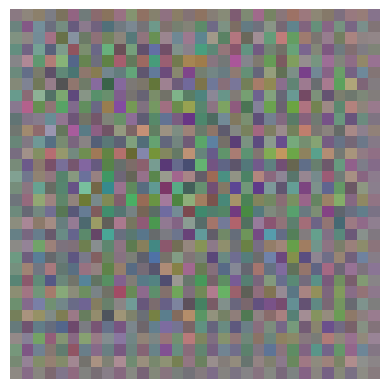

In [ ]:
show(fake[0].detach(), is_normalized=False)

In [ ]:
#@title ignore the error
input_size = [(100, 1, 1), (1,)]
summary(cgenerator, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 192, 4, 4]         338,112
              ReLU-2            [-1, 192, 4, 4]               0
            Conv2d-3            [-1, 192, 4, 4]         331,968
       BatchNorm2d-4            [-1, 192, 4, 4]             384
              ReLU-5            [-1, 192, 4, 4]               0
   ConvTranspose2d-6            [-1, 192, 8, 8]         331,968
       BatchNorm2d-7            [-1, 192, 8, 8]             384
              ReLU-8            [-1, 192, 8, 8]               0
            Conv2d-9            [-1, 192, 8, 8]         331,968
      BatchNorm2d-10            [-1, 192, 8, 8]             384
             ReLU-11            [-1, 192, 8, 8]               0
  ConvTranspose2d-12           [-1, 96, 16, 16]         165,984
      BatchNorm2d-13           [-1, 96, 16, 16]             192
             ReLU-14           [-1, 96,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Discriminator

In [ ]:
class cDiscriminator(nn.Module):
    def __init__(self, num_classes, num_channels, num_filters):
        super().__init__()
        self.num_classes = num_classes
        # B is the batch size
        # Input shape: [B, num_channels + num_classes, 28, 28]
        self.net = nn.Sequential(
            nn.Conv2d(num_channels + num_classes, num_filters, kernel_size=4, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_filters, num_filters * 2, kernel_size=4, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1), # this collapse the signal into a single scalar per sample
            # output becomes [B, C, 1, 1]
            nn.Conv2d(num_filters * 2, 1, kernel_size=1, stride=1, padding=0),  # 7 -> 1
        )

    def forward(self, x, y):
        # x: [B, 1, 28, 28] <- the image whether real or fake
        # y: [B]            <- the class 0-9
        y = y.long()
        y_one_hot = F.one_hot(y, num_classes=self.num_classes)  # [B, num_classes]
        y_one_hot = y_one_hot.view(-1, self.num_classes, 1, 1)  # [B, 10, 1, 1]
        y_one_hot = y_one_hot.expand(-1, -1, x.shape[2], x.shape[3])  # [B, 10, 28, 28]

        x_cond = torch.cat([x, y_one_hot], dim=1)  # [B, 1+10, 28, 28]
        out = self.net(x_cond)
        return out.view(-1)  # flatten to [B]


In [ ]:
cdiscriminator = cDiscriminator(num_classes=num_classes, num_channels=num_channels, num_filters=64)
print(f'total params: {sum([p.numel() for p in cdiscriminator.parameters()]):,}')

total params: 144,961


In [ ]:
dum_x = torch.randn(2,3,32,32)
dum_y = torch.randint(0, 10, (2,))
logits = cdiscriminator(dum_x, dum_y)
logits.shape

torch.Size([2])

In [ ]:
logits

tensor([-0.0767,  0.1564], grad_fn=<ViewBackward0>)

In [ ]:
#@title ignore the error
input_size = [(3, 32, 32), (1,)]
summary(cdiscriminator, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]          13,376
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,200
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
 AdaptiveAvgPool2d-6            [-1, 128, 1, 1]               0
            Conv2d-7              [-1, 1, 1, 1]             129


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Training loop

In [ ]:
def train_step(criterion, generator, discriminator, g_opt, d_opt, real_images, real_labels, latent_dim, device):
    batch_size = real_images.size(0)

    # === 1. Train Discriminator ===
    discriminator.zero_grad()

    # Real labels (1), Fake labels (0)
    real_targets = torch.ones(batch_size, device=device)
    fake_targets = torch.zeros(batch_size, device=device)

    # ---- Real images ----
    real_preds = discriminator(real_images, real_labels)
    d_loss_real = criterion(real_preds, real_targets)

    # ---- Fake images ----
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(z, real_labels)  # use same labels for fair comparison

    fake_preds = discriminator(fake_images.detach(), real_labels)
    d_loss_fake = criterion(fake_preds, fake_targets)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_opt.step()

    # === 2. Train Generator ===
    generator.zero_grad()

    # Try to fool the discriminator
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(z, real_labels)
    fake_preds = discriminator(fake_images, real_labels)

    g_loss = criterion(fake_preds, real_targets)  # want to be classified as "real"
    g_loss.backward()
    g_opt.step()

    return d_loss.item(), g_loss.item()

In [ ]:
num_epochs = 1
criterion = nn.BCEWithLogitsLoss()  # handles sigmoid internally
g_optimizer, d_optimizer = torch.optim.Adam(cgenerator.parameters(), lr=2e-4), torch.optim.Adam(cdiscriminator.parameters(), lr=2e-4)
cgenerator, cdiscriminator = cgenerator.to(device), cdiscriminator.to(device)

In [ ]:
d_loss, g_loss = 0, 0
for epoch in range(num_epochs):
    for real_images, real_labels in mnist_dl:
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)

        d_loss, g_loss = train_step(criterion, cgenerator, cdiscriminator,
                                    g_optimizer, d_optimizer,
                                    real_images, real_labels,
                                    latent_dim=latent_dims, device=device)

    print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

Epoch [1/1] | D_loss: 1.3385 | G_loss: 0.7241


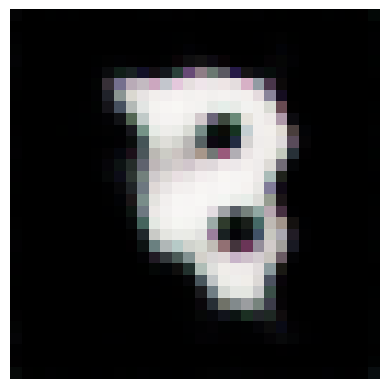

In [ ]:
dum_z = torch.randn(1,100,1,1).to(device)
dum_y = torch.tensor([8]).to(device)
fake = cgenerator(dum_z, dum_y)
show(fake[0].detach(), is_normalized=False)

as you can see the generated image is poor and if you train and try yourself you'll notice that the condition doesn't influence the generation that much why?? because its been one hot encoded which barely contain rich context unlike using embeddings to express the labels!

## InfoGAN
* [infoGAN (2016)](https://arxiv.org/abs/1606.03657) Xi Chen et al. Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets

Implementation creditted to [JunsikChoi](https://github.com/JunsikChoi/Pytorch-InfoGAN/blob/master/src/models/mnist/generator.py) repo

InfoGAN is a generative Adversarial Network that is able to learn disentangled representations in a completely unsupervised manner.

It also maximizes the mutual information between a small subset of the latent
variables and the observation. We derive a lower bound of the mutual information
objective that can be optimized efficiently. Specifically, InfoGAN successfully
disentangles writing styles from digit shapes on the MNIST dataset, pose from
lighting of 3D rendered images, and background digits from the central digit on
the SVHN dataset. [direct citation to the abstract](https://arxiv.org/pdf/1606.03657)


---

here a direct citation to the original paper

<img src="https://drive.google.com/uc?id=17IyGP48abEfKtaDKm5YcCzrCMFrRW1qI" width="1000"/>

---



You can think of InfoGAN as Variational Autoencoders (VAEs)



---

<img src="https://drive.google.com/uc?id=1qpV9Ke5lmeb30lcY5ZIMyiTeKEQTtlHK" width="1000"/>


### Generator

In [ ]:
class InfoGenerator(nn.Module):
    def __init__(self, dim_z, n_c_disc, dim_c_disc, dim_c_cont):
        """
        remember that we have a z which is latent random variable
        and we have c which is the latent code which can be discrete and continuous

        n_c_disc,  number of discrete c (this will resemble discrete attributes such as the identity of the digit)
        dim_c_disc, its dimension
        dim_c_cont dimension of continuous c
        """
        super().__init__()
        self.dim_latent = dim_z + n_c_disc * dim_c_disc + dim_c_cont
        self.fc1 = nn.Linear(in_features=self.dim_latent,
                             out_features=1024,
                             bias=False)
        self.bn1 = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(in_features=1024,
                             out_features=7*7*128,
                             bias=False)
        self.bn2 = nn.BatchNorm1d(7*7*128)
        self.upconv3 = nn.ConvTranspose2d(in_channels=128,
                                          out_channels=64,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.upconv4 = nn.ConvTranspose2d(in_channels=64,
                                          out_channels=1,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1)

    def forward(self, z):
        # Layer 1: [-1, dim_latent] -> [-1, 1024]
        z = F.relu(self.bn1(self.fc1(z)))

        # Layer 2: [-1, 1024] -> [-1, 7*7*128]
        z = F.relu(self.bn2(self.fc2(z)))

        # Shape Change: [-1, 7*7*128] -> [-1, 128, 7, 7]
        z = z.view(-1, 128, 7, 7)

        # Layer 3: [-1, 128, 7, 7] -> [-1, 64, 14, 14]
        z = F.relu(self.bn3(self.upconv3(z)))

        # Layer 4: [-1, 64, 14, 14] -> [-1, 1, 28, 28]
        img = torch.sigmoid(self.upconv4(z))

        return img

total params: 6,645,185


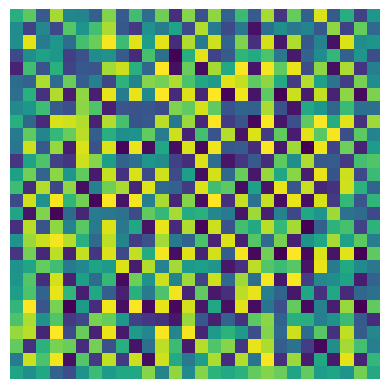

In [ ]:
dim_z = 62            # noise
n_c_disc = 1          # number of discrete codes
dim_c_disc = 10       # categories per discrete code
dim_c_cont = 2        # number of continuous codes

batch_size = 128
G = InfoGenerator(dim_z=dim_z, n_c_disc=n_c_disc, dim_c_disc=dim_c_disc, dim_c_cont=dim_c_cont)
print(f'total params: {sum([p.numel() for p in G.parameters()]):,}')
noise = torch.randn(batch_size, 62)
disc_code = torch.zeros(batch_size, 10).scatter_(1, torch.randint(0, 10, (batch_size, 1)), 1)
cont_code = torch.rand(batch_size, 2) * 2 - 1  # Uniform(-1,1)

z = torch.cat([noise, disc_code, cont_code], dim=1)
fake_images = G(z)
show(fake_images[0].detach())

### Discriminator

Discriminator also from [JunsikChoi](https://github.com/JunsikChoi/Pytorch-InfoGAN/blob/master/src/models/mnist/discriminator.py) repo

In [ ]:
class InfoDiscriminator(nn.Module):
    '''Shared Part of Discriminator and Recognition Model'''

    def __init__(self, n_c_disc, dim_c_disc, dim_c_cont):
        super().__init__()
        self.dim_c_disc = dim_c_disc
        self.dim_c_cont = dim_c_cont
        self.n_c_disc = n_c_disc
        # Shared layers
        self.module_shared = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            Reshape(-1, 128*7*7),
            nn.Linear(in_features=128*7*7, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

        # Layer for Disciminating (discriminator head)
        self.module_D = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

        # Q-network for mutual information approximation
        self.module_Q = nn.Sequential(
            nn.Linear(in_features=1024, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

        self.latent_disc = nn.Sequential(
            nn.Linear(
                in_features=128, out_features=self.n_c_disc*self.dim_c_disc),
            Reshape(-1, self.n_c_disc, self.dim_c_disc),
            nn.Softmax(dim=2)
        )

        self.latent_cont_mu = nn.Linear(
            in_features=128, out_features=self.dim_c_cont)

        self.latent_cont_var = nn.Linear(
            in_features=128, out_features=self.dim_c_cont)

    def forward(self, z):
        out = self.module_shared(z)
        probability = self.module_D(out)
        probability = probability.squeeze()
        internal_Q = self.module_Q(out)
        c_disc_logits = self.latent_disc(internal_Q)
        c_cont_mu = self.latent_cont_mu(internal_Q)
        c_cont_var = torch.exp(self.latent_cont_var(internal_Q))
        return probability, c_disc_logits, c_cont_mu, c_cont_var


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [ ]:
batch_size = 128

D_Q = InfoDiscriminator(n_c_disc=n_c_disc, dim_c_disc=dim_c_disc, dim_c_cont=dim_c_cont)
print(f'total params: {sum([p.numel() for p in D_Q.parameters()]):,}')

z = torch.randn(batch_size, 1, 28, 28)
decision = D_Q(z)
print(f"Output Types:\n"
      f" - D(x): {decision[0].shape} (real/fake probability)\n"
      f" - c_disc: {decision[1].shape} (discrete latent logits)\n"
      f" - c_mu: {decision[2].shape} (mean of continuous)\n"
      f" - c_var: {decision[3].shape} (variance of continuous)")

total params: 6,692,431
Output Types:
 - D(x): torch.Size([128]) (real/fake probability)
 - c_disc: torch.Size([128, 1, 10]) (discrete latent logits)
 - c_mu: torch.Size([128, 2]) (mean of continuous)
 - c_var: torch.Size([128, 2]) (variance of continuous)


### Training

In [ ]:
def sample_latent(batch_size, dim_z=62, dim_c_disc=10, dim_c_cont=2, device='cpu'):
    z_noise = torch.randn(batch_size, dim_z, device=device)
    c_disc = torch.zeros(batch_size, dim_c_disc, device=device)
    idx = torch.randint(0, dim_c_disc, (batch_size,), device=device)
    c_disc[torch.arange(batch_size), idx] = 1
    c_cont = torch.rand(batch_size, dim_c_cont, device=device) * 2 - 1
    return z_noise, c_disc, c_cont, idx

In [ ]:
class NLLGaussianLoss(nn.Module):
    def __init__(self):
        super(NLLGaussianLoss, self).__init__()

    def forward(self, x, mu, var):
        return 0.5 * torch.log(2 * torch.pi * var) + (x - mu).pow(2) / (2 * var)

In [ ]:
lr_G = 0.001
lr_D = 0.0002
beta1 = 0.5
beta2 = 0.999

optim_G = optim.Adam(
    list(G.parameters()) +
    list(D_Q.module_Q.parameters()) +
    list(D_Q.latent_disc.parameters()) +
    list(D_Q.latent_cont_mu.parameters()),
    lr=0.001, betas=(0.5, 0.999)
)

optim_D = optim.Adam(
    list(D_Q.module_shared.parameters()) +
    list(D_Q.module_D.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
adversarial_loss = torch.nn.BCELoss()
categorical_loss = torch.nn.CrossEntropyLoss()
continuous_loss = NLLGaussianLoss()

In [ ]:
def train_infogan(generator, discriminator, device, data_loader, num_epochs=50,
                  dim_z=62, dim_c_disc=10, dim_c_cont=2,
                  lambda_disc=1.0, lambda_cont=0.1):
    adversarial_loss = nn.BCELoss()
    categorical_loss = nn.CrossEntropyLoss()
    continuous_loss = NLLGaussianLoss()

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(data_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Sample latent codes
            z_noise = torch.randn(batch_size, dim_z, device=device)
            c_disc = torch.zeros(batch_size, dim_c_disc, device=device)
            idx = torch.randint(0, dim_c_disc, (batch_size,), device=device)
            c_disc[torch.arange(batch_size), idx] = 1
            c_cont = torch.rand(batch_size, dim_c_cont, device=device) * 2 - 1
            z = torch.cat([z_noise, c_disc, c_cont], dim=1)

            # Train Discriminator
            optim_D.zero_grad()
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            prob_real, _, _, _ = discriminator(real_images)
            prob_fake, _, _, _ = discriminator(generator(z).detach())

            loss_D_real = adversarial_loss(prob_real, real_labels)
            loss_D_fake = adversarial_loss(prob_fake, fake_labels)
            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optim_D.step()

            # Train Generator + Q
            optim_G.zero_grad()
            fake_images = generator(z)
            prob_fake, disc_logits, mu, var = discriminator(fake_images)

            loss_G = adversarial_loss(prob_fake, real_labels)
            loss_c_disc = categorical_loss(disc_logits.squeeze(), idx)
            loss_c_cont = continuous_loss(c_cont, mu, var).mean()

            loss_info = loss_G + lambda_disc * loss_c_disc + lambda_cont * loss_c_cont
            loss_info.backward()
            optim_G.step()
            g_history.append(loss_G.cpu().detach().item()); d_history.append(loss_D.cpu().detach().item())

            if i % 5 == 0:
                # Sample latent codes
                z_noise, disc_code, cont_code, idx = sample_latent(batch_size)
                z = torch.cat([z_noise, disc_code, cont_code], dim=1).to(device)

                # Generate fake images
                fake_images = generator(z)

                # Display first generated image
                clear_output(wait=True)  # clear previous plot
                plt.imshow(fake_images[0].detach().cpu().squeeze(), cmap='gray')
                plt.title("Generated Sample")
                plt.axis("off")
                plt.pause(0.001)  # allow plot to update without blocking

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {loss_D.item():.4f} | "
              f"Loss_G: {loss_G.item():.4f} | Info Loss: {loss_info.item():.4f}")

In [ ]:
g_history, d_history = [], []

In [ ]:
G, D_Q = G.to(device), D_Q.to(device)

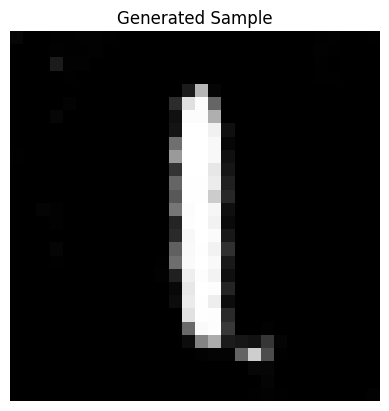

Epoch [1/1] | Loss_D: 1.2634 | Loss_G: 0.9479 | Info Loss: 2.4577


In [ ]:
train_infogan(G, D_Q, device, mnist_dl28, num_epochs=1,
                  dim_z=62, dim_c_disc=10, dim_c_cont=2,
                  lambda_disc=1.0, lambda_cont=0.1)

trained for only 4 epochs

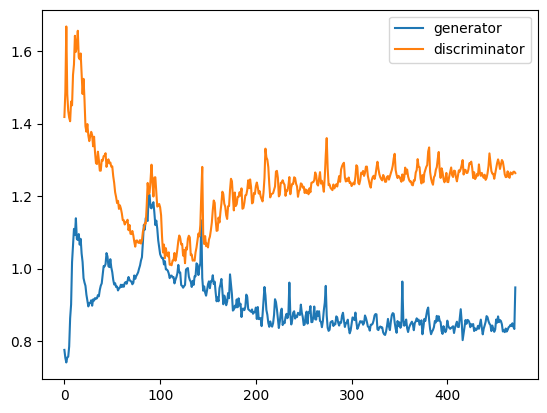

In [ ]:
plt.plot(g_history, label='generator')
plt.plot(d_history, label='discriminator')
plt.legend()

In [ ]:
#@title latent manipulation of continuous attributes (style/thickness)
def visualize_continuous(generator, device, dim_z=62, dim_c_disc=10, dim_c_cont=2,
                         num_classes=10, steps=10, sweep_dim=0):
    """
    Varies one continuous latent code while keeping others fixed.
    sweep_dim: 0 or 1 (choose which continuous latent code to sweep)
    """
    generator.eval()
    z_noise = torch.randn(1, dim_z).repeat(num_classes * steps, 1)

    # Create one-hot discrete codes for each digit class
    c_disc = torch.zeros(num_classes * steps, dim_c_disc)
    for i in range(num_classes):
        c_disc[i * steps:(i + 1) * steps, i] = 1

    # Create continuous code where one dim is swept
    c_cont = torch.zeros(num_classes * steps, dim_c_cont)
    values = torch.linspace(-2, 2, steps)
    for i in range(num_classes):
        for j in range(steps):
            c_cont[i * steps + j, sweep_dim] = values[j]

    z = torch.cat([z_noise, c_disc, c_cont], dim=1).to(device)
    with torch.no_grad():
        imgs = generator(z).cpu()

    grid = make_grid(imgs, nrow=steps, normalize=True, pad_value=1)
    plt.figure(figsize=(steps, num_classes))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Varying continuous latent dim {sweep_dim}")
    plt.axis("off")
    plt.show()

sometimes Style is learned in dim 1 and thickness in dim 0

what the model might learned at once:
* Rotation

* Skew/slant

* Writing style

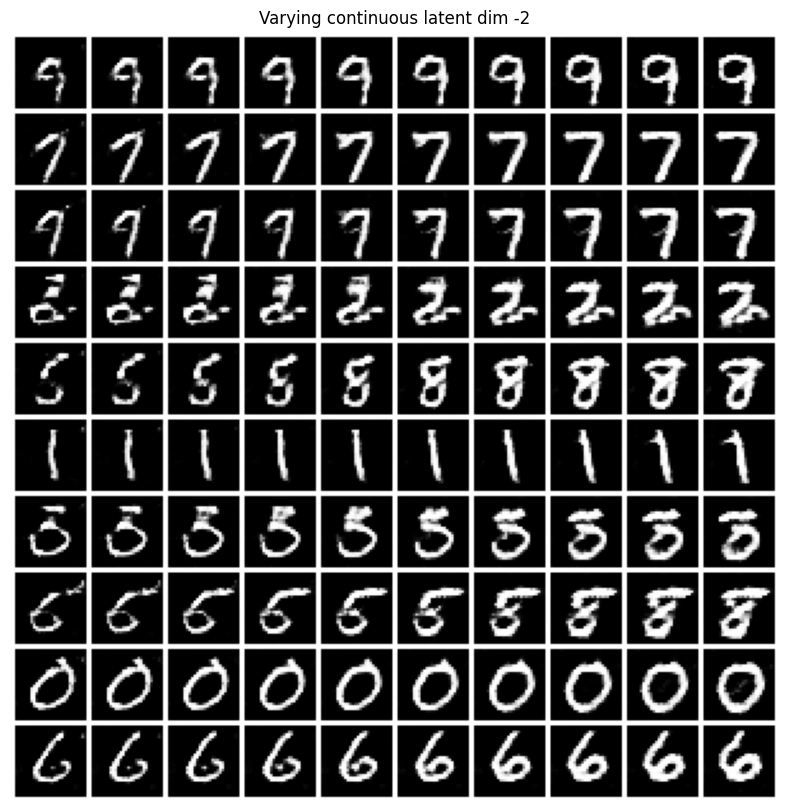

In [ ]:
visualize_continuous(
    generator=G,
    device=device,
    dim_z=62,
    dim_c_disc=10,
    dim_c_cont=2,
    num_classes=10,          # show all digits
    steps=10,                # number of continuous steps (e.g., -2 to 2)
    sweep_dim=-2              # vary continuous latent, every dim is something regarding a style
)


In [ ]:
#@title latent manipulation of discrete attributes (digit identity)
def visualize_discrete(generator, device, dim_z=62, dim_c_disc=10, dim_c_cont=2,
                       fixed_cont_value=0.0, steps=10):
    """
    Fix z and continuous codes, vary discrete class (0–9).
    """
    generator.eval()
    z_noise = torch.randn(steps, dim_z)

    c_disc = torch.zeros(steps, dim_c_disc)
    for i in range(steps):
        c_disc[i, i] = 1

    c_cont = torch.full((steps, dim_c_cont), fixed_cont_value)

    z = torch.cat([z_noise, c_disc, c_cont], dim=1).to(device)
    with torch.no_grad():
        imgs = generator(z).cpu()

    grid = make_grid(imgs, nrow=steps, normalize=True, pad_value=1)
    plt.figure(figsize=(steps, 1.5))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Varying discrete latent (digit identity)")
    plt.axis("off")
    plt.show()

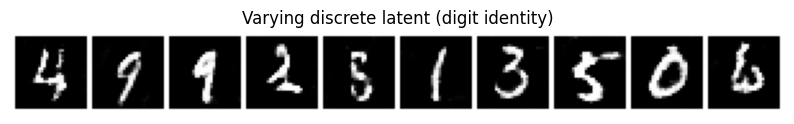

In [ ]:
visualize_discrete(
    generator=G,             # your trained generator
    device=device,           # 'cuda' or 'cpu'
    dim_z=62,
    dim_c_disc=10,
    dim_c_cont=2,
    fixed_cont_value=-1.0     # keep stroke/style fixed
)

## Pix2Pix GAN
* [Pix2Pix GAN (2016)](https://arxiv.org/abs/1611.07004) Phillip et al. Image-to-Image Translation with Conditional Adversarial Networks

#### Generator

##### Encoder

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

##### Decoder

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

##### Full generator archeticture

In [ ]:
def Generator():
  output_channels = 3
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

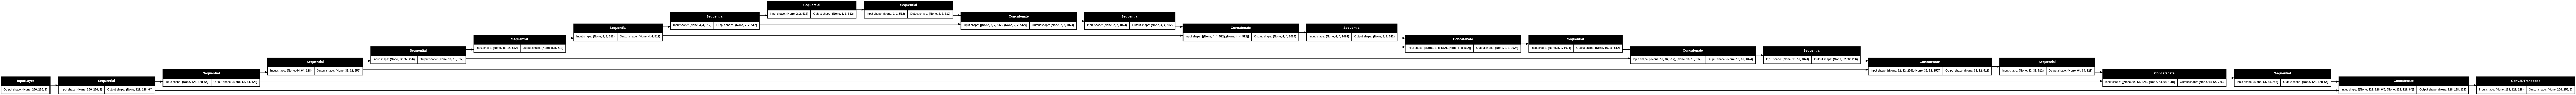

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, rankdir="LR")

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

#### Discriminator

Notice that the discriminator here in this paper doesn't use MLP at all! rather a PatchGAN kind of discriminator which improves the learning in the generator on a local level (group of pixels such as the group that forms the nose or the eyes etc...)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

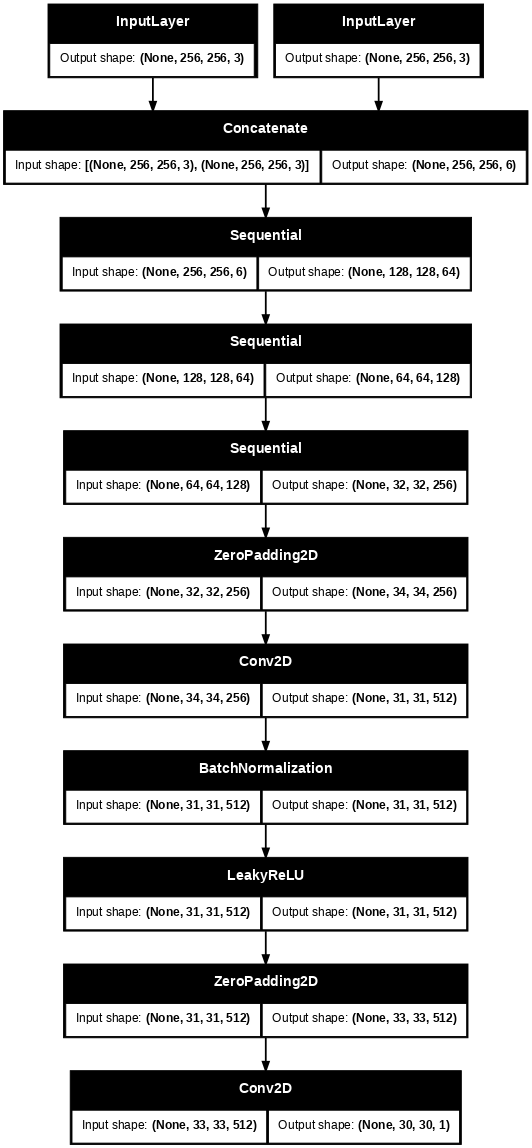

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

#### training

In [ ]:
@tf.function
def gan_train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(train_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      clear_output(wait=True)  # Use clear_output from IPython

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    gan_train_step(input_image, target, step)

    #raining step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    #checkpointing! the model every 1k steps
    if (step + 1) % 1000 == 0:
    #   checkpoint.save(file_prefix=checkpoint_prefix)
      print(f"Checkpoint saved at step {step+1}")

## CycleGAN
* [CycleGAN (2017)](https://arxiv.org/abs/1703.10593) Jun et al. Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

cycle gans can be said to be the continuation of Pix2Pix gans

implemenation is creditted to [aitorzip repo!](https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py)

### Generator

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)
                        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
                    nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True)
                    ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [
                        nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True)
                        ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [
                ResidualBlock(in_features)
            ]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [
                        nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True)
                        ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [
                    nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh()
                    ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [
                    nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True)
                    ]

        model += [
                    nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128),
                    nn.LeakyReLU(0.2, inplace=True)
                    ]

        model += [
                    nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256),
                    nn.LeakyReLU(0.2, inplace=True)
                    ]

        model += [
                    nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512),
                    nn.LeakyReLU(0.2, inplace=True)
                    ]

        # FCN classification layer
        model += [
                    nn.Conv2d(512, 1, 4, padding=1)
                    ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

### Training

#### Data

In [ ]:
#@title utilities
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
#@title dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/horse2zebra-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/horse2zebra-dataset


In [ ]:
#@title custom dataset loading
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}A', '*.jpg')))
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}B', '*.jpg')))
        print('sorting')
        self.files_A.sort(key=natural_sort_key)
        self.files_B.sort(key=natural_sort_key)
        if not (len(self.files_B)==len(self.files_A)):
            if len(self.files_A)>len(self.files_B):
                self.files_A = self.files_A[:len(self.files_B)]
            else:
                self.files_B = self.files_B[:len(self.files_A)]
        print('finished_sorting')


    def __getitem__(self, index):
        item_A = Image.open(self.files_A[index])
        item_B = Image.open(self.files_B[index])
        item_A = item_A.convert('RGB')
        item_B = item_B.convert('RGB')
        item_A = self.transform(item_A)
        item_B = self.transform(item_B)
        return {
            'A':item_A,
            'B':item_B,
        }
        # return self.files_A[index], self.files_B[index]

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
!ls /kaggle/input/horse2zebra-dataset/

n02381460_1000.jpg  n02381460_20.jpg	n02381460_4310.jpg  n02381460_640.jpg
n02381460_1010.jpg  n02381460_2100.jpg	n02381460_4370.jpg  n02381460_6640.jpg
n02381460_1030.jpg  n02381460_2120.jpg	n02381460_440.jpg   n02381460_6690.jpg
n02381460_1090.jpg  n02381460_2150.jpg	n02381460_4410.jpg  n02381460_670.jpg
n02381460_1100.jpg  n02381460_2280.jpg	n02381460_4420.jpg  n02381460_6790.jpg
n02381460_1110.jpg  n02381460_2460.jpg	n02381460_4430.jpg  n02381460_690.jpg
n02381460_1120.jpg  n02381460_2540.jpg	n02381460_4450.jpg  n02381460_6920.jpg
n02381460_1160.jpg  n02381460_2580.jpg	n02381460_4470.jpg  n02381460_6950.jpg
n02381460_120.jpg   n02381460_2650.jpg	n02381460_4530.jpg  n02381460_7140.jpg
n02381460_1210.jpg  n02381460_2710.jpg	n02381460_4550.jpg  n02381460_7170.jpg
n02381460_1260.jpg  n02381460_2870.jpg	n02381460_4630.jpg  n02381460_7190.jpg
n02381460_1300.jpg  n02381460_2890.jpg	n02381460_4640.jpg  n02381460_7230.jpg
n02381460_1350.jpg  n02381460_2940.jpg	n02381460_4650.jpg  n02381460_

In [ ]:
size = 128
batchSize = 16
n_cpu = 2  # Reduced for Colab
dataroot = path

In [ ]:
### DATASET
transforms_ = [
    transforms.Resize(int(size * 1.12), Image.BICUBIC), # <- bi-cubic is an interpolation technique in increasing the image size and is better than Linear interpolation in terms of smoothness
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]
train_horse_zebra_dataset = ImageDataset(dataroot, transforms_=transforms_, mode='train', unaligned=True)
test_horse_zebra_dataset = ImageDataset(dataroot, transforms_=transforms_, mode='test', unaligned=True)

train_dl = DataLoader(
    train_horse_zebra_dataset,
    batch_size=batchSize, shuffle=True, num_workers=n_cpu, persistent_workers=True
)

test_dl = DataLoader(
    test_horse_zebra_dataset,
    batch_size=batchSize, shuffle=False, num_workers=n_cpu, persistent_workers=True
)

sorting
finished_sorting
sorting
finished_sorting


In [ ]:
img_dict = next(iter(test_dl))
imga, imgb = img_dict['A'], img_dict['B']
imga.shape, imgb.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 3, 128, 128]))

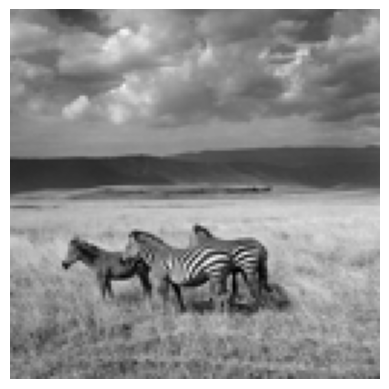

In [ ]:
show(imga[0])
show(imgb[0])

#### Hyperparams and neural network initialization

In [ ]:
### hyperparams
epoch = 0
n_epochs = 5
lr = 0.0002
decay_epoch = 1
input_nc = 3    #input channels
output_nc = 3   #output channels
use_cuda = torch.cuda.is_available()

In [ ]:
### NETWORK INITIALIZATION
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if use_cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

<ipython-input-23-f9dd1ee4f0a6>:37: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
### LOSS FUNCTIONS
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

### OPTIMIZERS & SCHEDULERS
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

In [ ]:
### MEMORY ALLOCATION
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

#### Training loop

In [ ]:
g_history, d_history = [], []

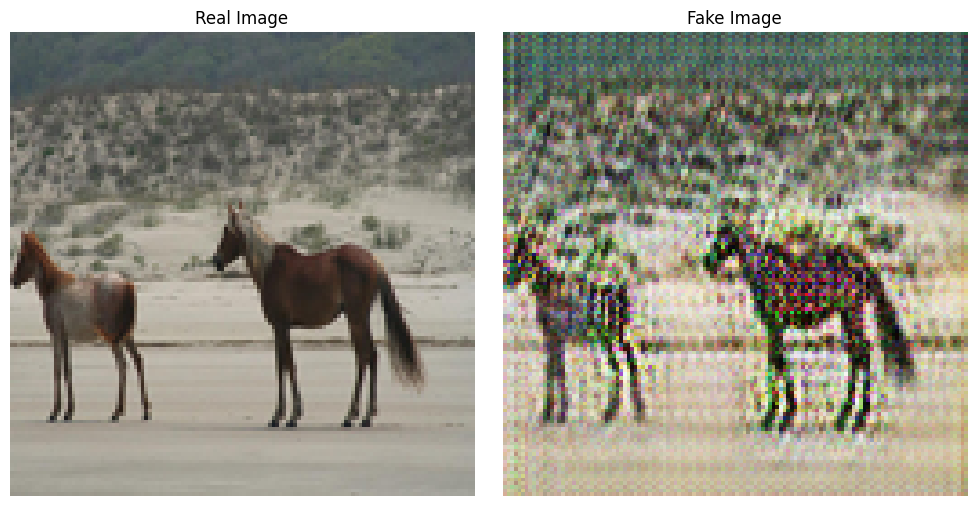

[Epoch 4/5] [Batch 65/67] [D loss: 0.31] [G loss: 6.33]
[Epoch 4/5] [Batch 66/67] [D loss: 0.33] [G loss: 7.57]


In [ ]:
### TRAINING LOOP
for ep in range(epoch, n_epochs):
    for i, batch in enumerate(train_dl):
        real_A = Variable(batch['A'].to(device))
        real_B = Variable(batch['B'].to(device))

        if i % 5 == 0:
            clear_output(wait=True)
            netG_A2B.eval()
            with torch.no_grad():
                fake_image = netG_A2B(imga.to(device))

            real_image = (imga * 0.5) + 0.5
            fake_image = (fake_image * 0.5) + 0.5  # De-normalize to [0,1]
            real_image_np = real_image[0].cpu().detach().permute(1, 2, 0)
            fake_image_np = fake_image[0].cpu().detach().permute(1, 2, 0)

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(real_image_np)
            axes[0].set_title("Real Image")
            axes[0].axis('off')

            axes[1].imshow(fake_image_np)
            axes[1].set_title("Fake Image")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

        netG_A2B.train()
        ### Generators
        optimizer_G.zero_grad()
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * 5.0
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * 5.0

        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0
        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()

        ### Discriminator A
        optimizer_D_A.zero_grad()
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        ### Discriminator B
        optimizer_D_B.zero_grad()
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)

        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        print(f"[Epoch {ep}/{n_epochs}] [Batch {i}/{len(train_dl)}] [D loss: {(loss_D_A + loss_D_B).item():.2f}] [G loss: {loss_G.item():.2f}]")
        g_history.append(loss_G.item()); d_history.append((loss_D_A + loss_D_B).item())
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

#### Inspection

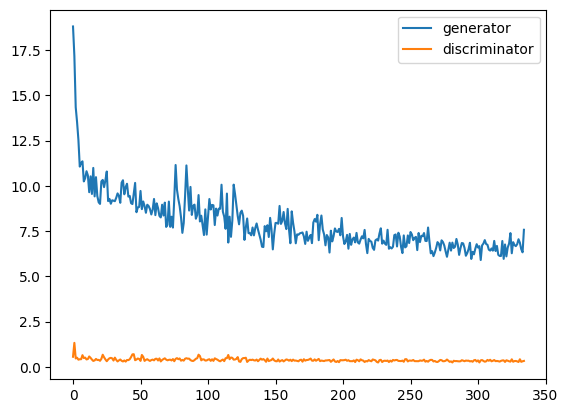

In [ ]:
plt.plot(g_history, label='generator')
plt.plot(d_history, label='discriminator')
plt.legend()

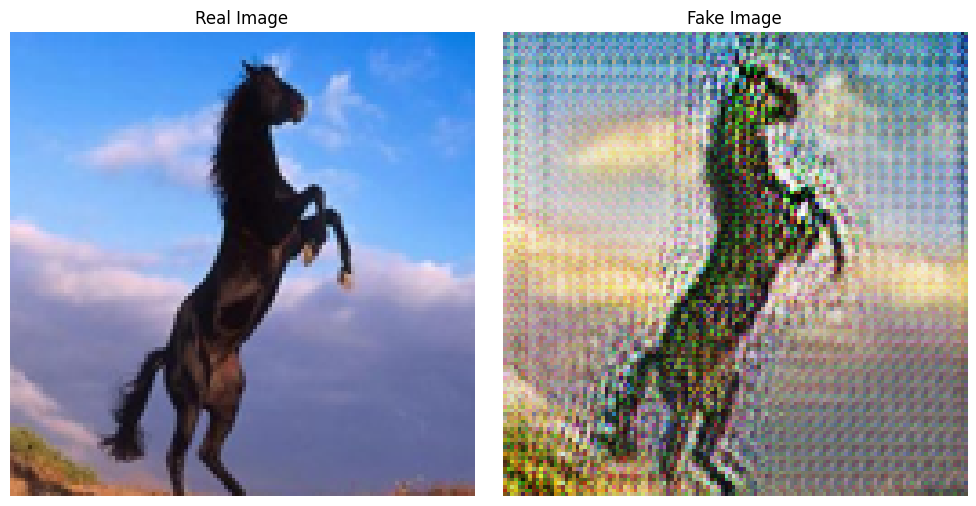

In [ ]:
# imga
netG_A2B.eval()
with torch.no_grad():
    fake_image = netG_A2B(imga.to(device))
i=8
real_image = (imga * 0.5) + 0.5
fake_image = (fake_image * 0.5) + 0.5  # De-normalize to [0,1]
real_image_np = real_image[i].cpu().detach().permute(1, 2, 0)
fake_image_np = fake_image[i].cpu().detach().permute(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(real_image_np)
axes[0].set_title("Real Image")
axes[0].axis('off')

axes[1].imshow(fake_image_np)
axes[1].set_title("Fake Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

As you can see here, the generator is trying to put zebra stripes!!

with enough training and not facing the risk of mode collapse you will get results like this!!:

<img src="https://drive.google.com/uc?id=19UN_HdFfzKQZtftiH3W91EGFDs0GmVFN" width="1000"/>

<img src="https://drive.google.com/uc?id=1PaMaWtRiz7GmkyetZ9pChvYdHmdyhF6J" width="1000"/>

## WGAN & WGAN GP (Wasserstein GAN with gradient penalty)
* [WGAN (2017)](https://arxiv.org/abs/1701.07875) Martin et al. Wasserstein GAN
* [WGAN-GP (2017)](https://arxiv.org/abs/1704.00028) Ishaan et al. Improved Training of Wasserstein GANs

credit goes to repo [Zeleni9](https://github.com/Zeleni9/pytorch-wgan/blob/master/images/latent_fashion.png)

### Generator

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

### Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)

### Combining them

In [ ]:
class WGAN_GP(object):
    def __init__(self, args):
        print("WGAN_GradientPenalty init model.")
        self.G = Generator(args.channels)
        self.D = Discriminator(args.channels)
        self.C = args.channels

        # Check if cuda is available
        self.check_cuda(args.cuda)

        # WGAN values from paper
        self.learning_rate = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.batch_size = 64

        # WGAN_gradient penalty uses ADAM
        self.d_optimizer = optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        self.g_optimizer = optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))

        # Set the logger
        self.logger = Logger('./logs')
        self.logger.writer.flush()
        self.number_of_images = 10

        self.generator_iters = args.generator_iters
        self.critic_iter = 5
        self.lambda_term = 10

    def get_torch_variable(self, arg):
        if self.cuda:
            return Variable(arg).cuda(self.cuda_index)
        else:
            return Variable(arg)

    def check_cuda(self, cuda_flag=False):
        print(cuda_flag)
        if cuda_flag:
            self.cuda_index = 0
            self.cuda = True
            self.D.cuda(self.cuda_index)
            self.G.cuda(self.cuda_index)
            print("Cuda enabled flag: {}".format(self.cuda))
        else:
            self.cuda = False


    def train(self, train_loader):
        self.t_begin = t.time()
        # self.file = open("inception_score_graph.txt", "w")

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(train_loader)

        one = torch.tensor(1, dtype=torch.float)
        mone = one * -1
        if self.cuda:
            one = one.cuda(self.cuda_index)
            mone = mone.cuda(self.cuda_index)

        for g_iter in range(self.generator_iters):
            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True

            d_loss_real = 0
            d_loss_fake = 0
            Wasserstein_D = 0
            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()

                images = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                images, z = self.get_torch_variable(images), self.get_torch_variable(z)

                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean()
                d_loss_real.backward(mone)

                # Train with fake images
                z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))

                fake_images = self.G(z)
                d_loss_fake = self.D(fake_images)
                d_loss_fake = d_loss_fake.mean()
                d_loss_fake.backward(one)

                # Train with gradient penalty
                gradient_penalty = self.calculate_gradient_penalty(images.data, fake_images.data)
                gradient_penalty.backward()


                d_loss = d_loss_fake - d_loss_real + gradient_penalty
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
                print(f'  Discriminator iteration: {d_iter}/{self.critic_iter}, loss_fake: {d_loss_fake}, loss_real: {d_loss_real}')

            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()
            # train generator
            # compute loss with fake images
            z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean()
            g_loss.backward(mone)
            g_cost = -g_loss
            self.g_optimizer.step()
            print(f'Generator iteration: {g_iter}/{self.generator_iters}, g_loss: {g_loss}')
            # Saving model and sampling images every 1000th generator iterations
            if (g_iter) % SAVE_PER_TIMES == 0:
                self.save_model()
                # # Workaround because graphic card memory can't store more than 830 examples in memory for generating image
                # # Therefore doing loop and generating 800 examples and stacking into list of samples to get 8000 generated images
                # # This way Inception score is more correct since there are different generated examples from every class of Inception model
                # sample_list = []
                # for i in range(125):
                #     samples  = self.data.__next__()
                # #     z = Variable(torch.randn(800, 100, 1, 1)).cuda(self.cuda_index)
                # #     samples = self.G(z)
                #     sample_list.append(samples.data.cpu().numpy())
                # #
                # # # Flattening list of list into one list
                # new_sample_list = list(chain.from_iterable(sample_list))
                # print("Calculating Inception Score over 8k generated images")
                # # # Feeding list of numpy arrays
                # inception_score = get_inception_score(new_sample_list, cuda=True, batch_size=32,
                #                                       resize=True, splits=10)

                if not os.path.exists('training_result_images/'):
                    os.makedirs('training_result_images/')

                # Denormalize images and save them in grid 8x8
                z = self.get_torch_variable(torch.randn(800, 100, 1, 1))
                samples = self.G(z)
                samples = samples.mul(0.5).add(0.5)
                samples = samples.data.cpu()[:64]
                grid = utils.make_grid(samples)
                utils.save_image(grid, 'training_result_images/img_generatori_iter_{}.png'.format(str(g_iter).zfill(3)))

                # Testing
                time = t.time() - self.t_begin
                #print("Real Inception score: {}".format(inception_score))
                print("Generator iter: {}".format(g_iter))
                print("Time {}".format(time))

                # Write to file inception_score, gen_iters, time
                #output = str(g_iter) + " " + str(time) + " " + str(inception_score[0]) + "\n"
                #self.file.write(output)


                # ============ TensorBoard logging ============#
                # (1) Log the scalar values
                info = {
                    'Wasserstein distance': Wasserstein_D.data,
                    'Loss D': d_loss.data,
                    'Loss G': g_cost.data,
                    'Loss D Real': d_loss_real.data,
                    'Loss D Fake': d_loss_fake.data

                }

                for tag, value in info.items():
                    self.logger.scalar_summary(tag, value.cpu(), g_iter + 1)

                # (3) Log the images
                info = {
                    'real_images': self.real_images(images, self.number_of_images),
                    'generated_images': self.generate_img(z, self.number_of_images)
                }

                for tag, images in info.items():
                    self.logger.image_summary(tag, images, g_iter + 1)



        self.t_end = t.time()
        print('Time of training-{}'.format((self.t_end - self.t_begin)))
        #self.file.close()

        # Save the trained parameters
        self.save_model()

    def evaluate(self, test_loader, D_model_path, G_model_path):
        self.load_model(D_model_path, G_model_path)
        z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()
        grid = utils.make_grid(samples)
        print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
        utils.save_image(grid, 'dgan_model_image.png')


    def calculate_gradient_penalty(self, real_images, fake_images):
        eta = torch.FloatTensor(self.batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(self.batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
        if self.cuda:
            eta = eta.cuda(self.cuda_index)
        else:
            eta = eta

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        if self.cuda:
            interpolated = interpolated.cuda(self.cuda_index)
        else:
            interpolated = interpolated

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda(self.cuda_index) if self.cuda else torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # flatten the gradients to it calculates norm batchwise
        gradients = gradients.view(gradients.size(0), -1)

        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_term
        return grad_penalty

    def real_images(self, images, number_of_images):
        if (self.C == 3):
            return self.to_np(images.view(-1, self.C, 32, 32)[:self.number_of_images])
        else:
            return self.to_np(images.view(-1, 32, 32)[:self.number_of_images])

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            if self.C == 3:
                generated_images.append(sample.reshape(self.C, 32, 32))
            else:
                generated_images.append(sample.reshape(32, 32))
        return generated_images

    def to_np(self, x):
        return x.data.cpu().numpy()

    def save_model(self):
        torch.save(self.G.state_dict(), './generator.pkl')
        torch.save(self.D.state_dict(), './discriminator.pkl')
        print('Models save to ./generator.pkl & ./discriminator.pkl ')

    def load_model(self, D_model_filename, G_model_filename):
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, _) in enumerate(data_loader):
                yield images

    def generate_latent_walk(self, number):
        if not os.path.exists('interpolated_images/'):
            os.makedirs('interpolated_images/')

        number_int = 10
        # interpolate between twe noise(z1, z2).
        z_intp = torch.FloatTensor(1, 100, 1, 1)
        z1 = torch.randn(1, 100, 1, 1)
        z2 = torch.randn(1, 100, 1, 1)
        if self.cuda:
            z_intp = z_intp.cuda()
            z1 = z1.cuda()
            z2 = z2.cuda()

        z_intp = Variable(z_intp)
        images = []
        alpha = 1.0 / float(number_int + 1)
        print(alpha)
        for i in range(1, number_int + 1):
            z_intp.data = z1*alpha + z2*(1.0 - alpha)
            alpha += alpha
            fake_im = self.G(z_intp)
            fake_im = fake_im.mul(0.5).add(0.5) #denormalize
            images.append(fake_im.view(self.C,32,32).data.cpu())

        grid = utils.make_grid(images, nrow=number_int )

##

## SAGAN
* [SAGAN (2018)](https://arxiv.org/abs/1805.08318) Han Zhang et al. Self-Attention Generative Adversarial Networks

credit to repo [heykeetae](https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py)

### Self attention

In [ ]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation

        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        return out,attention

### Generator

In [ ]:
class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2

### Discriminator

[ACGAN (2016)](https://arxiv.org/pdf/1610.09585) Odena et al. Conditional Image Synthesis with Auxiliary Classifier GANs

In [ ]:
class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""
    '''
    to learn about auxiliary classifiers in gans go to: [ACGAN (2016)](https://arxiv.org/pdf/1610.09585) Odena et al. Conditional Image Synthesis with Auxiliary Classifier GANs
    '''

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2